### 演習22）以下の解説とサンプルコードを参考に，所望の熱伝導率と線膨張係数を持つ高分子のモノマーを設計せよ．物性の目標範囲を変化させて，生成されるモノマーの構造的な違いを考察せよ．

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import pickle as pk
from copy import deepcopy

import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Draw

from xenonpy.descriptor import Fingerprints
from xenonpy.datatools import Splitter, Scaler
from xenonpy.inverse.iqspr import NGram, GaussianLogLikelihood, IQSPR

from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import forestci as fci


Failed to import duecredit due to No module named 'duecredit'


In [2]:
dir_file = 'data/Book_data_MD.csv'
data = pd.read_csv(dir_file)


物性の分布を確認する。

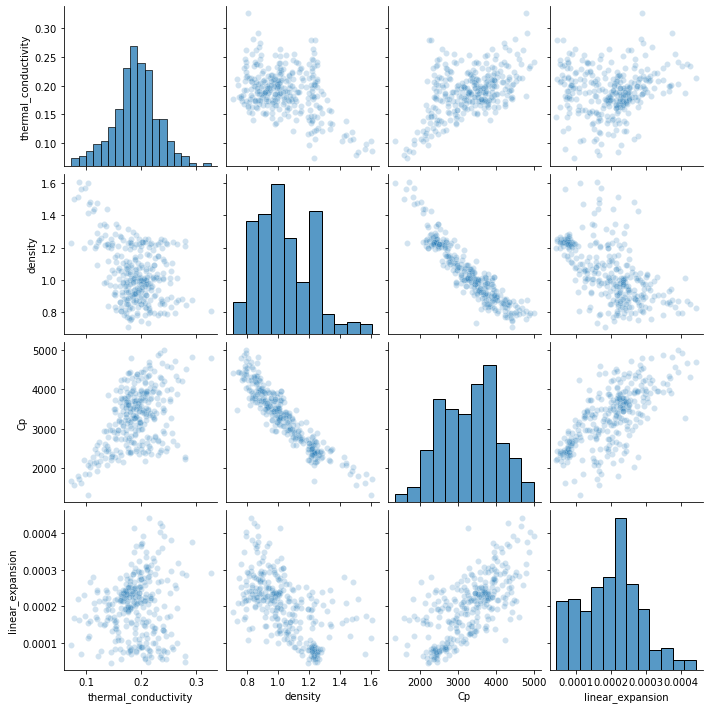

In [3]:
sns_plot = sns.pairplot(data.drop('SMILES', axis=1), plot_kws={'alpha':0.2})


XenonPyで記述子計算機を用意する（参考： 演習13）。

In [4]:
# prepare customized descriptor function

from xenonpy.descriptor.base import BaseDescriptor
from xenonpy.descriptor import ECFP, DescriptorFeature
from xenonpy.contrib.extend_descriptors.descriptor import Mordred2DDescriptor

class CustomDesc(BaseDescriptor):
    def __init__(self, n_jobs=-1, on_errors='nan', input_type='smiles'):
        super().__init__(on_errors=on_errors)
        self.n_jobs = n_jobs
        self.input_type = input_type

        self.rdkit_fp = ECFP(n_jobs, on_errors=on_errors, input_type=input_type, return_type='df', radius=3, n_bits=2048, counting=True)
        self.rdkit_fp = DescriptorFeature(on_errors=on_errors, input_type=input_type, return_type='df')

fp_fcn = CustomDesc()


In [5]:
# calculate descriptors
fp = fp_fcn.transform(data['SMILES'])

# check NA values in the descriptors
idx_na = fp.isna().sum() > 0
print(fp.isna().sum()[idx_na])

# avoid using Ipc because it is easy to overflow
idx_na['Ipc'] = True

fp_filtered = fp.loc[:, ~idx_na]
print(f'Final num. of descriptors = {fp_filtered.shape[1]}')

desc_picked = [x for x in fp_filtered.columns.values if ('ecfp6_c' not in x) and (x not in idx_na.index[idx_na])] 


MaxPartialCharge       283
MinPartialCharge       283
MaxAbsPartialCharge    283
MinAbsPartialCharge    283
BCUT2D_MWHI            300
BCUT2D_MWLOW           300
BCUT2D_CHGHI           300
BCUT2D_CHGLO           300
BCUT2D_LOGPHI          300
BCUT2D_LOGPLOW         300
BCUT2D_MRHI            300
BCUT2D_MRLOW           300
dtype: int64
Final num. of descriptors = 2243


In [6]:
# prepare customized descriptor function

from xenonpy.descriptor.base import BaseDescriptor
from xenonpy.descriptor import ECFP, DescriptorFeature

class CustomDesc_filtered(BaseDescriptor):
    def __init__(self, n_jobs=-1, on_errors='nan', input_type='smiles'):
        super().__init__(on_errors=on_errors)
        self.n_jobs = n_jobs
        self.input_type = input_type

        self.rdkit_fp = ECFP(n_jobs, on_errors=on_errors, input_type=input_type, return_type='df', radius=3, n_bits=2048, counting=True)
        self.rdkit_fp = DescriptorFeature(on_errors=on_errors, input_type=input_type, return_type='df', desc_list=desc_picked)

fp_fcn = CustomDesc_filtered()


すべてのMDデータを用いてランダムフォレストモデルを学習し、予測を行う (参考: 演習13)。

[実行に数分かかる。]

In [7]:
# x-axis: observation data, y-axis: prediction
def plot_prediction(x_tr, y_tr, x_te, y_te, dir_file):
    xy_min = min(np.concatenate([x_tr, x_te, y_tr, y_te]))
    xy_max = max(np.concatenate([x_tr, x_te, y_tr, y_te]))
    xy_del = xy_max - xy_min
    
    _ = plt.figure(figsize=(5,5))
    _ = plt.scatter(x_tr, y_tr, s=20, c='r', marker='x', alpha=0.3, label='Training')
    _ = plt.scatter(x_te, y_te, s=20, c='b', alpha=0.4, label='Test')
    _ = plt.rc('xtick',labelsize=14)
    _ = plt.rc('ytick',labelsize=14)
    _ = plt.xlabel('Prediction', fontsize=14)
    _ = plt.ylabel('Observation', fontsize=14)
    _ = plt.legend(fontsize=14)
    _ = plt.plot([xy_min,xy_max],[xy_min,xy_max],ls="--",c='k')
    _ = plt.savefig(dir_file, dpi = 500, bbox_inches = "tight")
    _ = plt.close()
    

In [8]:
%%time

dir_plot = 'output/演習22'
os.makedirs(dir_plot, exist_ok=True)

# target region of the design
target_prop = ['thermal_conductivity', 'linear_expansion']

# grids for hyperparameters
n_tree = [50, 100, 200]
max_feat_r = [0.3, 0.5, 0.7]

x_train = fp_filtered
max_feat = np.round([x*x_train.shape[1] for x in max_feat_r]).astype(int)
parameters = {'n_estimators': n_tree, 'max_features': max_feat}

# fixing random seed for reproducibility
sps = {}
np.random.seed (202202)
for prop in target_prop:
    sps[prop] = Splitter(data.shape[0], test_size=0, k_fold=5)

mdls = {}
np.random.seed (202202)
for prop, y_train in data[target_prop].iteritems():
    mdls[prop] = []
    prd_tr, prd_te = [], []
    obs_tr, obs_te = [], []
    for x_tr, x_te, y_tr, y_te in sps[prop].cv(x_train, y_train):
        # train model with hyperparameter tuning
        mdl = GridSearchCV(RFR(), parameters, scoring='neg_mean_squared_error')
        mdl.fit(x_tr, y_tr) # requires 1D vector for model training
        mdls[prop].append(deepcopy(mdl.best_estimator_))
        
        prd_tr.append(mdls[prop][-1].predict(x_tr))
        prd_te.append(mdls[prop][-1].predict(x_te))

        obs_tr.append(y_tr.values)
        obs_te.append(y_te.values)
    
    plot_prediction(np.concatenate(prd_tr), np.concatenate(obs_tr), np.concatenate(prd_te), np.concatenate(obs_te), f'{dir_plot}/RF_{prop}.png')
    

CPU times: user 4min 16s, sys: 1.25 s, total: 4min 17s
Wall time: 4min 18s


尤度の関数とターゲット物性領域を設定する。

In [9]:
class bootstrap_fcn():
    def __init__(self, ms, var):
        self.Ms = ms
        self.Var = var
    def predict(self, x):
        val = np.array([m.predict(x) for m in self.Ms])
        return np.mean(val, axis = 0), np.sqrt(np.var(val, axis = 0) + self.Var)

# include basic measurement noise
c_var = {'thermal_conductivity': 0.05**2, 'linear_expansion': 0.00005**2}

# generate a dictionary for the final models used to create the likelihood
custom_mdls = {key: bootstrap_fcn(value, c_var[key]) for key, value in mdls.items()}

# set target range
target_range = {'thermal_conductivity': (0.24, np.inf), 'linear_expansion': (-np.inf, 0.00015)}

# import descriptor calculator and forward model to iQSPR
prd_mdls = GaussianLogLikelihood(descriptor=fp_fcn, targets=target_range, **custom_mdls)


物性の予測値の分布を描く。

In [10]:
# predict property values
pred = prd_mdls.predict(data['SMILES'])
print(pred.head())

# calculate log-likelihood for a given target property region
tmp_ll = prd_mdls.log_likelihood(data['SMILES'])
tmp = tmp_ll.sum(axis = 1, skipna = True)


   thermal_conductivity: mean  thermal_conductivity: std  \
0                    0.228028                   0.050617   
1                    0.109654                   0.050020   
2                    0.169699                   0.050223   
3                    0.205657                   0.050104   
4                    0.233679                   0.051242   

   linear_expansion: mean  linear_expansion: std  
0                0.000383               0.000053  
1                0.000174               0.000050  
2                0.000228               0.000051  
3                0.000219               0.000050  
4                0.000097               0.000050  


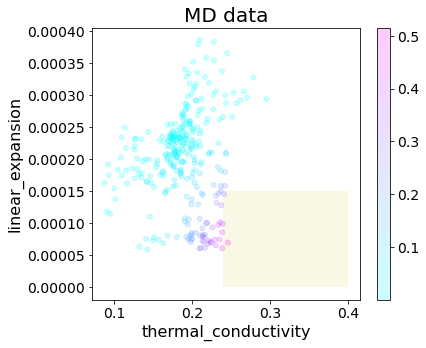

In [11]:
# check the predicted likelihood
dot_scale = 500
l_std = np.sqrt(pred['thermal_conductivity: std']**2+pred['linear_expansion: std']**2)

_ = plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((0.24,0),0.16,0.00015,fc='y',alpha=0.1)
_ = plt.gca().add_patch(rectangle)
im = plt.scatter(pred['thermal_conductivity: mean'], pred['linear_expansion: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
_ = plt.title('MD data', fontsize=20)
_ = plt.xlabel('thermal_conductivity', fontsize=16)
_ = plt.ylabel('linear_expansion', fontsize=16)
_ = plt.colorbar(im)
_ = plt.show()


分子生成器（NGram）を訓練して、iQSPRを実行する。この演習はMDデータにある300個のポリマー分子を使う。実際には学習したい分子構造の多様性によって、もっと大量なデータが必要である。

注意：一つの分子に対して複数のSMILES表現があるため、まずはSMILESを変化させて、NGramの訓練データに追加する。

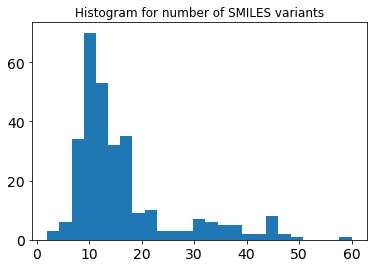

CPU times: user 526 ms, sys: 5.48 ms, total: 531 ms
Wall time: 530 ms


In [12]:
%%time

np.random.seed(202202) # fix the random seed

# Method: expand n-gram training set with randomly reordered SMILES
# (we show one of the many possible ways of doing it)
n_reorder = 20 # pick a fixed number of re-ordering

# convert the SMILES to canonical SMILES in RDKit (not necessary in general)
cans = []
for smi in data['SMILES']:
    # remove some molecules in the full SMILES list that may lead to error
    try:
        cans.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi)))
    except:
        print(smi)
        pass

mols = [Chem.MolFromSmiles(smi) for smi in cans]
smi_reorder_all = []
smi_reorder = []
for mol in mols:
    idx = list(range(mol.GetNumAtoms()))
    tmp = [Chem.MolToSmiles(mol,rootedAtAtom=x) for x in range(len(idx))]
    smi_reorder_all.append(np.array(list(set(tmp))))
    smi_reorder.append(np.random.choice(smi_reorder_all[-1],n_reorder,
                                        replace=(len(smi_reorder_all[-1]) < n_reorder)))

n_uni = [len(x) for x in smi_reorder_all]
plt.hist(n_uni, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram for number of SMILES variants")
plt.show()


拡張したSMILESデータを使ってNGramを訓練する。

注意：実行に20分程かかるので、代わりにこのセルをスキップして、次のセルで訓練済みのNGramを導入することも可能である。

In [13]:
%%time

# flatten out the list and train the N-gram
flat_list = [item for sublist in smi_reorder for item in sublist]

n_gram_reorder = NGram(reorder_prob=0.5)
n_gram_reorder.fit(flat_list,train_order=30)
# save results
_ = joblib.dump(n_gram_reorder, 'data/ngram_MD_reO20_O30.xz')


100%|███████████████████████████████████████| 6000/6000 [13:22<00:00,  7.47it/s]


CPU times: user 13min 23s, sys: 21.7 s, total: 13min 45s
Wall time: 13min 30s


NGramの長い訓練時間を回避するため、代わりに事前に用意した分子生成器（NGram）を導入する。

In [14]:
n_gram = joblib.load('data/ngram_MD_reO20_O30.xz')


300のMD library SMILESから訓練したNGramは多様性が足りないため、iQSPR-VというをiQSPRの新しいバージョンを使って、局所モードのトラッピングを回避し、最終的に候補の多様性を高めることができる。iQSPR-Vというのは、iQSPRの実行中に、分子を順次修正するのではなく、リザーバー（全ての初期構造として使われる分子構造）からランダムに分子のサンプルを抽出し、一部低尤度の提案分子と置き換えることで、仮想分子設計プロセスにおいて継続的に構造の多様性を維持することができる。

In [ ]:
# import codes of iQSPR-V (can also be found in the contrib folder on xenonpy github)
%run data/modifier.py
%run data/iQSPR_V.py


iQSPRの事前準備：リザーバーと尤度関数のアニーリング（逆温度の非減少列）betaを設定する。

In [32]:
# set up initial molecules for iQSPR-V
init_samples = data['SMILES'].values

# set up annealing schedule in iQSPR
beta1 = np.hstack([np.linspace(0.01,0.2,15),np.linspace(0.21,0.4,5),np.linspace(0.4,1,5),np.linspace(1,1,5)])
beta2 = np.hstack([np.linspace(0.2/15,0.2,15),np.linspace(0.21,0.4,5),np.linspace(0.4,1,5),np.linspace(1,1,5)])
beta = pd.DataFrame({'thermal_conductivity': beta1, 'linear_expansion': beta2})
print(beta)


    thermal_conductivity  linear_expansion
0               0.010000          0.013333
1               0.023571          0.026667
2               0.037143          0.040000
3               0.050714          0.053333
4               0.064286          0.066667
5               0.077857          0.080000
6               0.091429          0.093333
7               0.105000          0.106667
8               0.118571          0.120000
9               0.132143          0.133333
10              0.145714          0.146667
11              0.159286          0.160000
12              0.172857          0.173333
13              0.186429          0.186667
14              0.200000          0.200000
15              0.210000          0.210000
16              0.257500          0.257500
17              0.305000          0.305000
18              0.352500          0.352500
19              0.400000          0.400000
20              0.400000          0.400000
21              0.550000          0.550000
22         

iQSPR-Vを実行する。

注意：実行に数分かかる。普通に警告メッセージがいっぱい出るので、演習の時は無視してください。

In [18]:
%%time

dir_out = 'output/演習22'
os.makedirs(dir_out, exist_ok=True)

# update NGram parameters for this exampleHOMO-LUMO gap
n_gram.set_params(del_range=[1,20],max_len=300, reorder_prob=0.5, sample_order=(1,30))

# set up likelihood and n-gram models in iQSPR
iqspr_reorder = IQSPR_V(estimator=prd_mdls, modifier=n_gram)
    
np.random.seed(2022) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for iStep, (s, ll, p, freq) in enumerate(iqspr_reorder(init_samples, beta, yield_lpf=True, ratio=0.5)):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open(f'{dir_out}/iQSPRV_results_case1.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)
    

/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)
/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)
RDKit ERROR: [23:44:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10 11 12 13 14 15 23 24 25 26 27 28 32 33 36 37 38
[23:44:36] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 10 11 12 13 14 15 23 24 25 26 27 28 32 33 36 37 38

RDKit ER

CPU times: user 1min 32s, sys: 1.92 s, total: 1min 34s
Wall time: 1min 42s


iQSPRの過程に尤度の変化：所望の物性に近つくことがわかる。

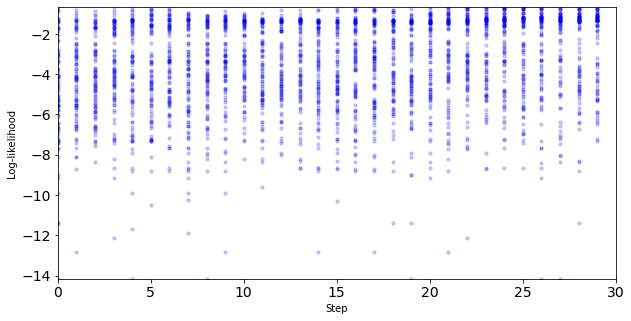

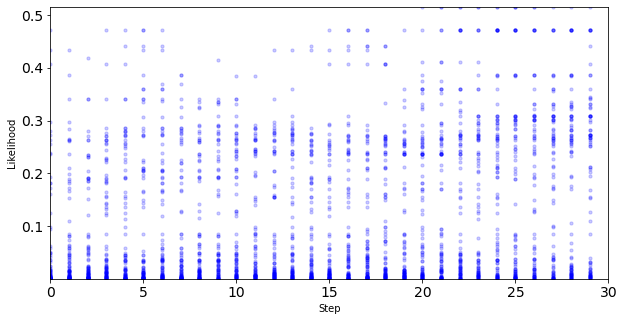

In [19]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(y_min,y_max)
_ = plt.xlabel('Step')
_ = plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(y_min,y_max)
_ = plt.xlabel('Step')
_ = plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()

iQSPRの過程に物性値の変化：iQSPR-Vは探索の過程に、提案した高分子の物性がターゲット領域にの収束は一見遅くなるが、NGramの訓練用データが少ない状況でも提案の高分子の多様性が高い。

[実行に数分かかる。]

In [20]:
%%time

# re-calculate the property values for the proposed molecules
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    tmp_fps = fp_fcn.transform(smis)
    FPs_samples.append(tmp_fps)

    tmp1, tmp2 = prd_mdls['thermal_conductivity'].predict(tmp_fps)
    x_mean.append(tmp1)
    x_std.append(tmp2)

    tmp1, tmp2 = prd_mdls['linear_expansion'].predict(tmp_fps)
    y_mean.append(tmp1)
    y_std.append(tmp2)

    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))


Range of std. dev.: (0.0500,0.0535)
CPU times: user 9.42 s, sys: 331 ms, total: 9.75 s
Wall time: 13.3 s


In [21]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = 'output/演習22/iQSPRV_case1_prd/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data['thermal_conductivity'],
    np.asarray([item for sublist in x_mean for item in sublist])))
x_max, x_min = max(max(flat_list), 0.5), min(flat_list)
flat_list = np.concatenate((data['linear_expansion'],
    np.asarray([item for sublist in y_mean for item in sublist])))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = iqspr_results_reorder['beta']

for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5

    _ = plt.figure(figsize=(5,5))
    rectangle = plt.Rectangle((0.24,0),0.16,0.00015,fc='y',alpha=0.1)
    _ = plt.gca().add_patch(rectangle)
    _ = plt.scatter(data['thermal_conductivity'], data['linear_expansion'],s=3, c='b', alpha=0.2)
    _ = plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.5)
    _ = plt.title('Step: %i (beta = %.3f, %.3f)' % (i,tmp_beta.iloc[i,0],tmp_beta.iloc[i,1]))
    _ = plt.xlim(x_min,x_max)
    _ = plt.ylim(y_min,y_max)
    _ = plt.xlabel('thermal_conductivity')
    _ = plt.ylabel('linear_expansion')
    #plt.show()
    _ = plt.savefig(ini_dir+'Step_%02i.png' % i, dpi = 500)
    _ = plt.close()
    

CPU times: user 8.24 s, sys: 149 ms, total: 8.39 s
Wall time: 8.66 s


iQSPRから提案した分子構造を描く。

[実行に数分かかる。]

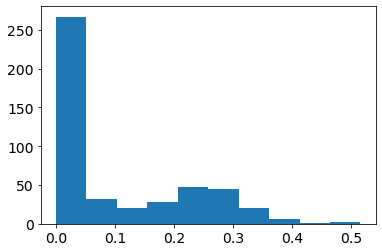

In [22]:
# extract all design candidates by removing some burn-in samples (user should remove all burn-in for a fully long iQSPR run)

n_burn = 20

# get the unique set of the candidates by converting all SMILES to canonical
fin_cand, idx = np.unique([Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in np.concatenate(iqspr_results_reorder["samples"][n_burn:])], return_index=True)
# calculate likelihood and property values of the candidates
fin_like = np.exp(np.concatenate([x.sum(axis=1) for x in iqspr_results_reorder["loglike"][n_burn:]])[idx])
fin_x_mu = np.concatenate(x_mean[n_burn:])[idx]
fin_x_sig = np.concatenate(x_std[n_burn:])[idx]
fin_y_mu = np.concatenate(y_mean[n_burn:])[idx]
fin_y_sig = np.concatenate(y_std[n_burn:])[idx]

# check the likelihood distribution of the candidates
# note that many almost zero likelihood cases exist because of the continuous redrawing from the reservoir
_ = plt.hist(fin_like)


In [23]:
%%time

# Draw the molecular structures of the candidates

# prepare a folder to save all the figures
ini_dir = 'output/演習22/iQSPRV_case1_smiles/'
os.makedirs(ini_dir, exist_ok=True)

n_total = 25 # plot the top 25 candidates with the highest likelihood
n_S = 25 # each plot contains only 25 molecules
idx = np.argsort(fin_like)[::-1][:n_total] # sort the candidates by likelihood values

for i in range(0, n_total, n_S):
    fig, ax = plt.subplots(5, 5)
    fig.set_size_inches(20, 20)
    fig.set_tight_layout(True)
    for j in range(n_S):
        xaxis = j // 5
        yaxis = j % 5
        try:
            img = Draw.MolToImage(Chem.MolFromSmiles(fin_cand[idx][i+j]))
            ax[xaxis, yaxis].clear()
            ax[xaxis, yaxis].set_frame_on(False)
            ax[xaxis, yaxis].imshow(img)
            ax[xaxis, yaxis].text(1,10,'Thermal cond.: %4.3f W/mK' % (fin_x_mu[idx][i+j]),fontsize=14)
            ax[xaxis, yaxis].text(1,40,'Linear exp.: %6.5f 1/K' % (fin_y_mu[idx][i+j]),fontsize=14)
        except:
            pass
        ax[xaxis, yaxis].set_axis_off()
    fig.savefig(f'{ini_dir}/No_{i}to{i+n_S}.png',dpi = 500)
    plt.close()
    

CPU times: user 4.46 s, sys: 156 ms, total: 4.61 s
Wall time: 4.64 s


提案した高分子は硬直の部分多いことは高い熱伝導率と繋がってると考えられる。

次は低い熱伝導率と低い線膨張係数を待つ高分子を目指します。尤度を再設定して、もう一回iQSPR-Vを実行する。

   thermal_conductivity: mean  thermal_conductivity: std  \
0                    0.228028                   0.050617   
1                    0.109654                   0.050020   
2                    0.169699                   0.050223   
3                    0.205657                   0.050104   
4                    0.233679                   0.051242   

   linear_expansion: mean  linear_expansion: std  
0                0.000383               0.000053  
1                0.000174               0.000050  
2                0.000228               0.000051  
3                0.000219               0.000050  
4                0.000097               0.000050  


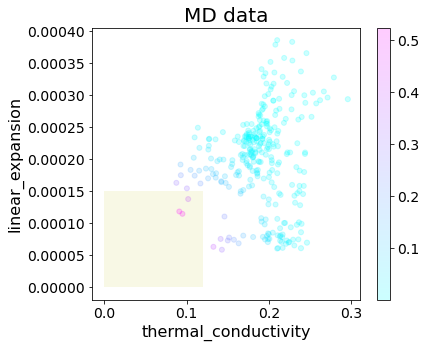

In [24]:
# set target range
target_range = {'thermal_conductivity': (-np.inf, 0.12), 'linear_expansion': (-np.inf, 0.00015)}

# import descriptor calculator and forward model to iQSPR
prd_mdls = GaussianLogLikelihood(descriptor=fp_fcn, targets=target_range, **custom_mdls)

# predict property values
pred = prd_mdls.predict(data['SMILES'])
print(pred.head())

# calculate log-likelihood for a given target property region
tmp_ll = prd_mdls.log_likelihood(data['SMILES'])
tmp = tmp_ll.sum(axis = 1, skipna = True)

# check the predicted likelihood
dot_scale = 500
l_std = np.sqrt(pred['thermal_conductivity: std']**2+pred['linear_expansion: std']**2)

_ = plt.figure(figsize=(6,5))
rectangle = plt.Rectangle((0,0),0.12,0.00015,fc='y',alpha=0.1)
_ = plt.gca().add_patch(rectangle)
im = plt.scatter(pred['thermal_conductivity: mean'], pred['linear_expansion: mean'], s=l_std*dot_scale, c=np.exp(tmp),alpha = 0.2,cmap=plt.get_cmap('cool'))
_ = plt.title('MD data', fontsize=20)
_ = plt.xlabel('thermal_conductivity', fontsize=16)
_ = plt.ylabel('linear_expansion', fontsize=16)
_ = plt.colorbar(im)
_ = plt.show()


In [25]:
# set up initial molecules for iQSPR-V
init_samples = data['SMILES'].values

# set up annealing schedule in iQSPR
beta1 = np.hstack([np.linspace(0.01,0.2,15),np.linspace(0.21,0.4,5),np.linspace(0.4,1,5),np.linspace(1,1,5)])
beta2 = np.hstack([np.linspace(0.2/15,0.2,15),np.linspace(0.21,0.4,5),np.linspace(0.4,1,5),np.linspace(1,1,5)])
beta = pd.DataFrame({'thermal_conductivity': beta1, 'linear_expansion': beta2})


In [26]:
%%time

dir_out = 'output/演習22'
os.makedirs(dir_out, exist_ok=True)

# update NGram parameters for this exampleHOMO-LUMO gap
n_gram.set_params(del_range=[1,20],max_len=300, reorder_prob=0.5, sample_order=(1,30))

# set up likelihood and n-gram models in iQSPR
iqspr_reorder = IQSPR_V(estimator=prd_mdls, modifier=n_gram)
    
np.random.seed(2022) # fix the random seed
# main loop of iQSPR
iqspr_samples1, iqspr_loglike1, iqspr_prob1, iqspr_freq1 = [], [], [], []
for iStep, (s, ll, p, freq) in enumerate(iqspr_reorder(init_samples, beta, yield_lpf=True, ratio=0.5)):
    iqspr_samples1.append(s)
    iqspr_loglike1.append(ll)
    iqspr_prob1.append(p)
    iqspr_freq1.append(freq)
# record all outputs
iqspr_results_reorder = {
    "samples": iqspr_samples1,
    "loglike": iqspr_loglike1,
    "prob": iqspr_prob1,
    "freq": iqspr_freq1,
    "beta": beta
}
# save results
with open(f'{dir_out}/iQSPRV_results_case2.obj', 'wb') as f:
    pk.dump(iqspr_results_reorder, f)
    

/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/pandas/core/series.py:1169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_values(loc, value)
RDKit ERROR: [23:46:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9
[23:46:41] Can't kekulize mol.  Unkekulized atoms: 4 5 6 7 9

RDKit ERROR: 
/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/xenonpy/inverse/iqspr/modifier.py:603: RuntimeWarning: can not convert *C(C*)c1c(cc(F)c1F)C(*)C* to Mol
  warnings.warn('can not convert %s to Mol' % new_smi, RuntimeWarning)
RDKit ERROR: [23:46:43] Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 9
[23:46:43] Can't kekulize mol.  Unkekulized atoms: 4 6 7 8 9

RDKit ERROR: 
/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_work

CPU times: user 1min 33s, sys: 1.63 s, total: 1min 34s
Wall time: 1min 39s


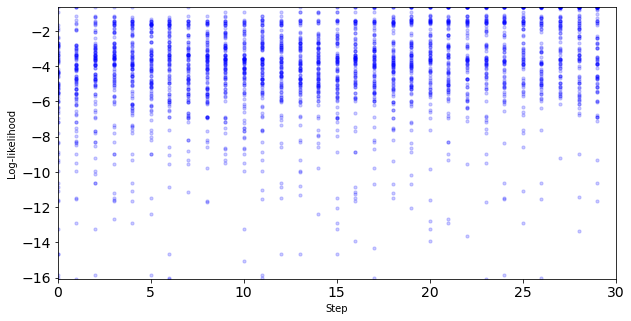

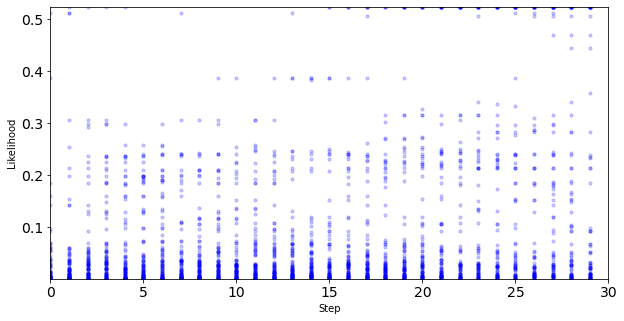

In [27]:
# plot the likelihood evolution

# set up the min and max boundary for the plots
tmp_list = [x.sum(axis = 1, skipna = True).values for x in iqspr_results_reorder["loglike"]]
flat_list = np.asarray([item for sublist in tmp_list for item in sublist])
y_max, y_min = max(flat_list), min(flat_list)

_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(y_min,y_max)
_ = plt.xlabel('Step')
_ = plt.ylabel('Log-likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), ll ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_loglike_reorder.png',dpi = 500)
#plt.close()

y_max, y_min = np.exp(y_max), np.exp(y_min)
_ = plt.figure(figsize=(10,5))
_ = plt.xlim(0,len(iqspr_results_reorder["loglike"]))
_ = plt.ylim(y_min,y_max)
_ = plt.xlabel('Step')
_ = plt.ylabel('Likelihood')
for i, ll in enumerate(tmp_list):
    _ = plt.scatter([i]*len(ll), np.exp(ll) ,s=10, c='b', alpha=0.2)
_ = plt.show()
#plt.savefig('iqspr_like_reorder.png',dpi = 500)
#plt.close()

In [28]:
%%time

# re-calculate the property values for the proposed molecules
x_mean, x_std, y_mean, y_std = [], [], [], []
r_std = []
FPs_samples = []
for i, smis in enumerate(iqspr_results_reorder["samples"]):
    tmp_fps = fp_fcn.transform(smis)
    FPs_samples.append(tmp_fps)

    tmp1, tmp2 = prd_mdls['thermal_conductivity'].predict(tmp_fps)
    x_mean.append(tmp1)
    x_std.append(tmp2)

    tmp1, tmp2 = prd_mdls['linear_expansion'].predict(tmp_fps)
    y_mean.append(tmp1)
    y_std.append(tmp2)

    r_std.append([np.sqrt(x_std[-1][i]**2 + y_std[-1][i]**2) for i in range(len(x_std[-1]))])

# flatten the list for max/min calculation
flat_list = [item for sublist in r_std for item in sublist]
print('Range of std. dev.: (%.4f,%.4f)' % (min(flat_list),max(flat_list)))


Range of std. dev.: (0.0500,0.0535)
CPU times: user 9.28 s, sys: 304 ms, total: 9.58 s
Wall time: 12.7 s


In [29]:
%%time

import os

# prepare a folder to save all the figures
ini_dir = 'output/演習22/iQSPRV_case2_prd/'
if not os.path.exists(ini_dir):
    os.makedirs(ini_dir)

flat_list = np.asarray([item for sublist in r_std for item in sublist])
s_max, s_min = max(flat_list), min(flat_list)
flat_list = np.concatenate((data['thermal_conductivity'],
    np.asarray([item for sublist in x_mean for item in sublist])))
x_max, x_min = max(max(flat_list), 0.3), min(min(flat_list), 0)
flat_list = np.concatenate((data['linear_expansion'],
    np.asarray([item for sublist in y_mean for item in sublist])))
y_max, y_min = max(flat_list), min(flat_list)
tmp_beta = iqspr_results_reorder['beta']

for i in range(len(r_std)):
    dot_size = 45*((np.asarray(r_std[i])-s_min)/(s_max-s_min)) + 5

    _ = plt.figure(figsize=(5,5))
    rectangle = plt.Rectangle((0,0),0.12,0.00015,fc='y',alpha=0.1)
    _ = plt.gca().add_patch(rectangle)
    _ = plt.scatter(data['thermal_conductivity'], data['linear_expansion'],s=3, c='b', alpha=0.2)
    _ = plt.scatter(x_mean[i], y_mean[i],s=dot_size, c='r', alpha=0.5)
    _ = plt.title('Step: %i (beta = %.3f, %.3f)' % (i,tmp_beta.iloc[i,0],tmp_beta.iloc[i,1]))
    _ = plt.xlim(x_min,x_max)
    _ = plt.ylim(y_min,y_max)
    _ = plt.xlabel('thermal_conductivity')
    _ = plt.ylabel('linear_expansion')
    #plt.show()
    _ = plt.savefig(ini_dir+'Step_%02i.png' % i, dpi = 500)
    _ = plt.close()
    

CPU times: user 8.14 s, sys: 134 ms, total: 8.27 s
Wall time: 8.57 s


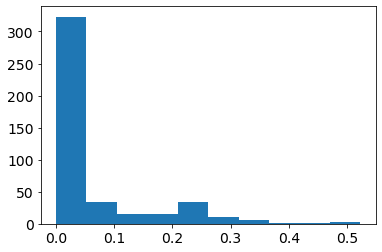

In [30]:
# extract all design candidates by removing some burn-in samples (user should remove all burn-in for a fully long iQSPR run)

n_burn = 20

# get the unique set of the candidates by converting all SMILES to canonical
fin_cand, idx = np.unique([Chem.MolToSmiles(Chem.MolFromSmiles(x)) for x in np.concatenate(iqspr_results_reorder["samples"][n_burn:])], return_index=True)
# calculate likelihood and property values of the candidates
fin_like = np.exp(np.concatenate([x.sum(axis=1) for x in iqspr_results_reorder["loglike"][n_burn:]])[idx])
fin_x_mu = np.concatenate(x_mean[n_burn:])[idx]
fin_x_sig = np.concatenate(x_std[n_burn:])[idx]
fin_y_mu = np.concatenate(y_mean[n_burn:])[idx]
fin_y_sig = np.concatenate(y_std[n_burn:])[idx]

# check the likelihood distribution of the candidates
# note that many almost zero likelihood cases exist because of the continuous redrawing from the reservoir
_ = plt.hist(fin_like)


In [31]:
%%time

# Draw the molecular structures of the candidates

# prepare a folder to save all the figures
ini_dir = 'output/演習22/iQSPRV_case2_smiles/'
os.makedirs(ini_dir, exist_ok=True)

n_total = 25 # plot the top 25 candidates with the highest likelihood
n_S = 25 # each plot contains only 25 molecules
idx = np.argsort(fin_like)[::-1][:n_total] # sort the candidates by likelihood values

for i in range(0, n_total, n_S):
    fig, ax = plt.subplots(5, 5)
    fig.set_size_inches(20, 20)
    fig.set_tight_layout(True)
    for j in range(n_S):
        xaxis = j // 5
        yaxis = j % 5
        try:
            img = Draw.MolToImage(Chem.MolFromSmiles(fin_cand[idx][i+j]))
            ax[xaxis, yaxis].clear()
            ax[xaxis, yaxis].set_frame_on(False)
            ax[xaxis, yaxis].imshow(img)
            ax[xaxis, yaxis].text(1,10,'Thermal cond.: %4.3f W/mK' % (fin_x_mu[idx][i+j]),fontsize=14)
            ax[xaxis, yaxis].text(1,40,'Linear exp.: %6.5f 1/K' % (fin_y_mu[idx][i+j]),fontsize=14)
        except:
            pass
        ax[xaxis, yaxis].set_axis_off()
    fig.savefig(f'{ini_dir}/No_{i}to{i+n_S}.png',dpi = 500)
    plt.close()
    

CPU times: user 4.5 s, sys: 106 ms, total: 4.6 s
Wall time: 4.62 s


Traceback (most recent call last):
  File "/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/rdkit/Chem/Descriptors.py", line 206, in FpDensityMorgan1
    def FpDensityMorgan1(x): return _FingerprintDensity(x, _rdMolDescriptors.GetMorganFingerprint, 1)
  File "/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/rdkit/Chem/Descriptors.py", line 203, in _FingerprintDensity
    return float(val) / mol.GetNumHeavyAtoms()
ZeroDivisionError: float division by zero
Traceback (most recent call last):
  File "/Users/stephenwu/opt/miniconda3/envs/iMacHome_xepy38_working/lib/python3.8/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
  File "/Users/stephenwu/opt/miniconda3/en

フッ素の存在は高分子の熱伝導率を下がることがよく知られる。結果、iQSPRは素朴にこの情報を最大限に利用して、フッ素が入っている高分子を提案した。